In [1]:
!pip install EMD-signal
!pip install vnstock

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.4 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.66.1
    Uninstalling tqdm-4.66.1:
      Successfully uninstalled tqdm-4.66.1


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import PyEMD as pe
from vnstock import *

Observations:  1634
            Open  High   Low  Close  Volume Ticker
Time                                              
2017-06-02  3410  3440  3290   3320    2580    VIB
2017-06-05  3320  3410  3290   3290   39900    VIB
2017-06-06  3310  3320  3290   3320   53340    VIB
2017-06-07  3420  3420  3310   3340   69855    VIB
2017-06-08  3310  3310  3290   3310   50310    VIB
2017-06-09  3290  3310  3290   3290   43100    VIB


<Axes: xlabel='Time'>

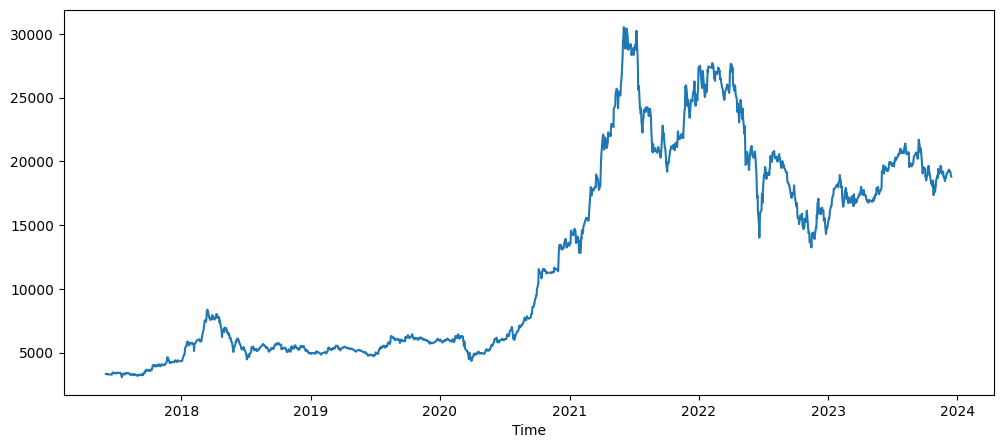

In [3]:
# Import data
VIB = stock_historical_data(symbol = "VIB", start_date="2017-06-01", end_date="2023-12-15", resolution="1D", type = "stock", beautify=True, decor=True, source = "DNSE")
from matplotlib import pyplot
print("Observations: ",len(VIB['Close']))
print(pd.DataFrame(VIB.head(6)))
train_dates = VIB.index
plt.figure(figsize=(12, 5))
VIB["Close"].plot()

In [4]:
VIB = VIB.reset_index(drop = True)
df = VIB['Close']
df

0        3320
1        3290
2        3320
3        3340
4        3310
        ...  
1629    19200
1630    19200
1631    19050
1632    18900
1633    18800
Name: Close, Length: 1634, dtype: int64

In [ ]:
## (A) CEEMDAN
#### 1. Thêm white noise vào chuỗi gốc s(t) thành chuỗi s1(t)
#### 2. Decompose chuỗi s1(t) bằng EMD ra các chuỗi IMF1 và Residue1
#### 3. Trung bình các chuỗi IMF1(t) thành mIMF1(t)
#### 4. r1(t) = s1(t) - mIMF1(t)
#### 5. Chuỗi mới s2(t) = r1(t) + coef*EMD(noise)
#### 6. Làm lại từ 1->5 đến khi chuỗi residue dừng

In [5]:
from PyEMD import EMD, CEEMDAN

In [6]:
ceemdan = CEEMDAN(range_thr=0.001, total_power_thr=0.01)
cIMFs = ceemdan.ceemdan(S=np.array(df.values), T= np.array(df.index))

In [7]:
pd.DataFrame(cIMFs.T, columns = ["IMF"+str(i+1) for i in range(cIMFs.shape[0])])

,IMF1,IMF2,IMF3,IMF4,IMF5,IMF6,IMF7,IMF8
0,4.439635,2.404516,20.609673,-50.962037,37.775321,15.922363,331.558147,2958.252381
1,-24.335752,-1.122596,25.568496,-54.146513,39.146942,15.583515,332.065397,2957.240512
2,-0.388632,5.137091,27.009161,-56.453344,40.635921,15.053787,332.756980,2956.249036
3,16.350866,11.783411,24.097797,-57.723922,42.250923,14.328963,333.634037,2955.277925
4,-0.220818,5.035292,16.543311,-57.781624,43.994087,13.404997,334.697603,2954.327153
...,...,...,...,...,...,...,...,...
1629,-53.822680,113.740923,333.140805,-229.411763,-783.901150,3098.792989,-4565.831723,21287.292598
1630,40.718885,56.243500,304.407592,-250.157458,-764.692122,3095.104654,-4561.048622,21279.423571
1631,12.070695,-13.027681,254.667428,-262.739914,-747.503207,3091.110886,-4556.065634,21271.487426
1632,-22.684938,-69.469893,192.790707,-267.549699,-732.499595,3086.812496,-4550.883227,21263.484150


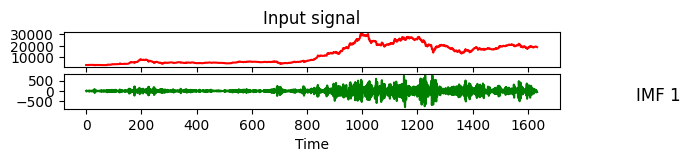

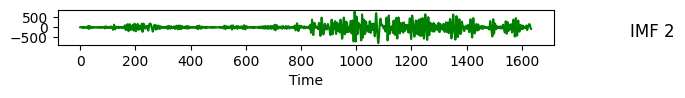

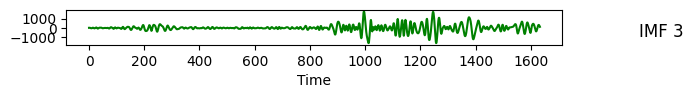

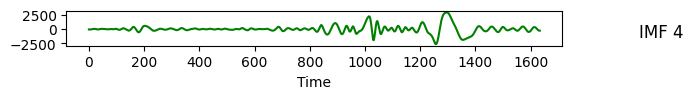

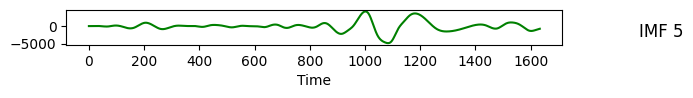

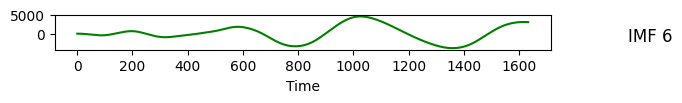

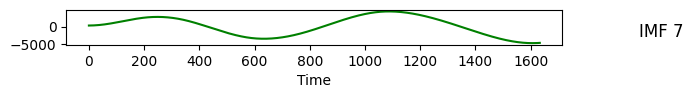

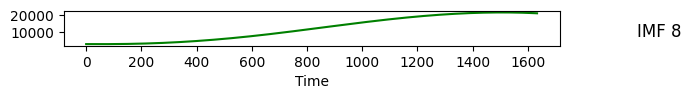

In [8]:
N = cIMFs.shape[0]+1
# Plot results
plt.subplot(N,1,1)
plt.plot(df.index, df.values, 'r')
plt.title("Input signal")
plt.xlabel("Time")

for n, imf in enumerate(cIMFs):
  plt.subplot(N,1,n+2)
  plt.plot(df.index, imf, 'g')
  plt.title("IMF "+str(n+1), x=1.2, y = 0)
  plt.xlabel("Time")
  plt.show()

In [9]:
# Tính residue
scIMF = cIMFs.sum(axis = 0).reshape(-1, 1)
residue = (np.array(df)-cIMFs.sum(axis = 0)).reshape(-1,1)

print("sIMF:", scIMF.shape)
print("Residue:", residue.shape)

sIMF: (1634, 1)
Residue: (1634, 1)


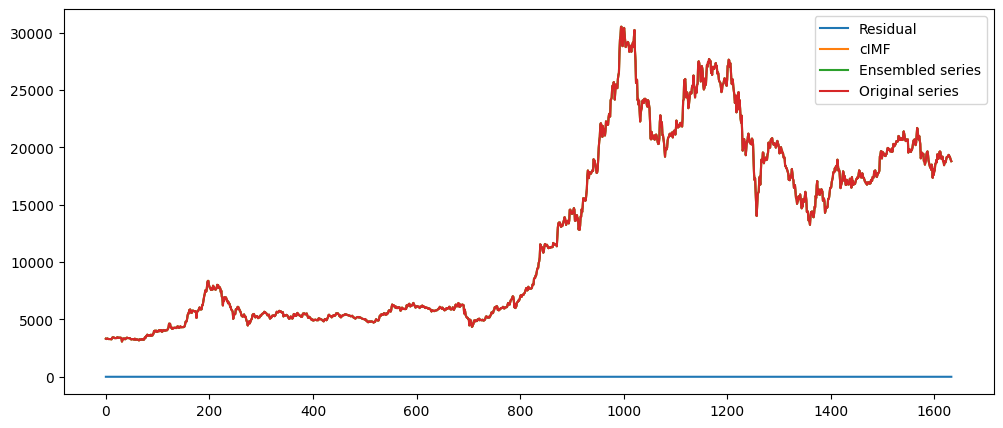

In [10]:
plt.figure(figsize=(12,5))
plt.plot(range(0,len(df)), residue)
plt.plot(range(0,len(df)), scIMF)
plt.plot(range(0,len(df)), scIMF+residue)
plt.plot(df)
plt.legend(["Residual", "cIMF", "Ensembled series", "Original series"])

plt.show()

In [11]:
# load các thư viện cần thiết
import math
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_predict, train_test_split,GridSearchCV,cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder,StandardScaler,PowerTransformer, MinMaxScaler, RobustScaler

In [12]:
cIMF = cIMFs.sum(axis = 0).reshape(-1, 1)+residue
cIMF

array([[ 3320.],
       [ 3290.],
       [ 3320.],
       ...,
       [19050.],
       [18900.],
       [18800.]])

In [13]:
# Scale data to 0-1
scaler = StandardScaler()
def Scaling (data):
    IMFscale = scaler.fit_transform(np.array(data))

    return IMFscale
IMFscale = Scaling(cIMF)
#train_scaled = scaler.inverse_transform(train_scaled)
#pd.DataFrame(train_scaled, columns=["IMF"+str(i+1) for i in range(cIMFs.shape[0])])

(1634, 1)
Train:  (1470, 1)
Test:  (164, 1)


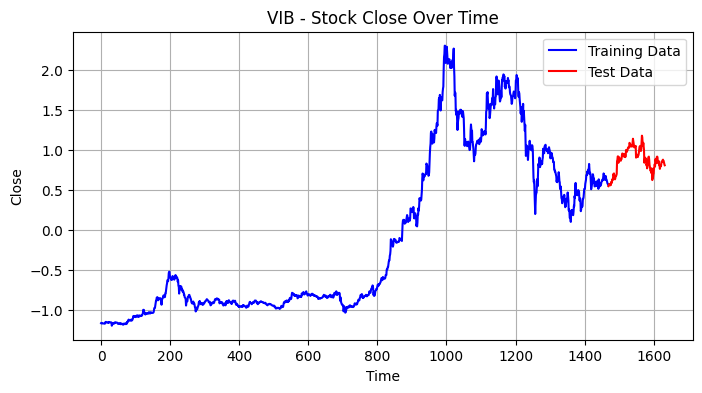

In [14]:
print(IMFscale.shape)
# Chia train test
train_size = int(0.9*IMFscale.shape[0])
test_size = int(0.1*IMFscale.shape[0])
train_data = IMFscale[:train_size].reshape(-1,1)
test_data = IMFscale[train_size:].reshape(-1,1)

print("Train: ", train_data.shape)
print("Test: ", test_data.shape)

# Plotting both training and test data on the same chart
plt.figure(figsize=(8, 4))

plt.plot(range(train_size), train_data, linestyle='-', color='b', label='Training Data')
plt.plot(range(train_size -1,  train_size+test_size), test_data, linestyle='-',  color='r', label='Test Data')


plt.title('VIB - Stock Close Over Time')
plt.xlabel('Time')
plt.ylabel('Close')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
trainX = []
trainY = []

n_past = 60
n_future = 1

for i in range(n_past, len(train_data) - n_future + 1):
    past_sequence = train_data[i - n_past:i, 0:train_data.shape[1]]  # Exclude the first column ("Close") for trainX
    future_sequence = train_data[i + n_future - 1: i + n_future, 0]  # Use the "Close" column for trainY

    trainX.append(past_sequence)
    trainY.append(future_sequence)

trainX, trainY = np.array(trainX), np.array(trainY)
print("X train: ", trainX.shape)
print("Y train: ", trainY.shape)

X train:  (1410, 60, 1)
Y train:  (1410, 1)


In [16]:
testX = []
testY = []

for i in range(n_past, len(test_data) - n_future + 1):
    past_sequence = test_data[i - n_past:i, 0:test_data.shape[1]]  # Exclude the first column ("Close") for trainX
    future_sequence = test_data[i + n_future - 1: i + n_future, 0]  # Use the "Close" column for trainY

    testX.append(past_sequence)
    testY.append(future_sequence)

testX, testY = np.array(testX), np.array(testY)

print("X test: ", testX.shape)
print("Y test: ", testY.shape)

X test:  (104, 60, 1)
Y test:  (104, 1)


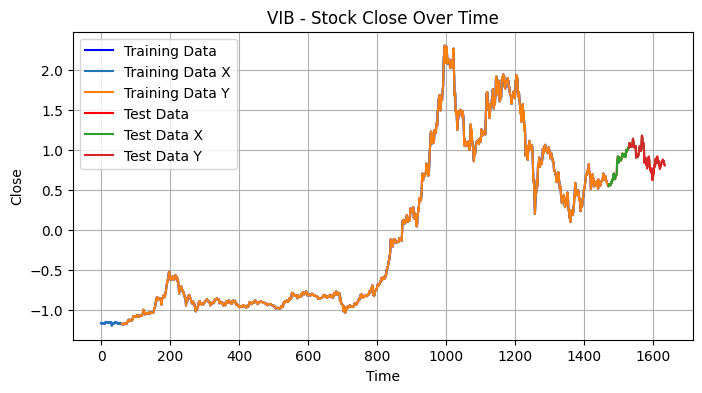

In [17]:
# Plotting both training and test data on the same chart
plt.figure(figsize=(8, 4))

plt.plot(range(train_size), train_data, linestyle='-', color='b', label='Training Data')
plt.plot(range(train_size-n_past), trainX[:,0,0], linestyle='-', label='Training Data X')
plt.plot(range(n_past,train_size), trainY[:,0], linestyle='-', label='Training Data Y')
plt.plot(range(train_size, train_size+test_size+1), test_data, linestyle='-',  color='r', label='Test Data')
plt.plot(range(train_size, train_size+test_size-n_past+1), testX[:,0,0], linestyle='-',  label='Test Data X')
plt.plot(range(train_size+n_past, train_size+test_size+1), testY[:,0], linestyle='-', label='Test Data Y')


plt.title('VIB - Stock Close Over Time')
plt.xlabel('Time')
plt.ylabel('Close')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
# Tạo model lstm cho việc training
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))
model.compile(optimizer='adam', loss='mape')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 29345 (114.63 KB)
Trainable params: 29345 (114.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
# fit the model
history = model.fit(trainX, trainY, epochs=30, batch_size=4, validation_split=0.1, verbose=1)

Epoch 1/30
318/318 [==============================] - 18s 45ms/step - loss: 28.8057 - val_loss: 22.8562
Epoch 2/30
318/318 [==============================] - 14s 43ms/step - loss: 21.2438 - val_loss: 38.7188
Epoch 3/30
318/318 [==============================] - 14s 43ms/step - loss: 19.8031 - val_loss: 19.0377
Epoch 4/30
318/318 [==============================] - 14s 43ms/step - loss: 18.1771 - val_loss: 23.1482
Epoch 5/30
318/318 [==============================] - 13s 41ms/step - loss: 18.1608 - val_loss: 17.1968
Epoch 6/30
318/318 [==============================] - 15s 48ms/step - loss: 17.2903 - val_loss: 16.8311
Epoch 7/30
318/318 [==============================] - 14s 43ms/step - loss: 16.9172 - val_loss: 21.1965
Epoch 8/30
318/318 [==============================] - 14s 43ms/step - loss: 16.8461 - val_loss: 14.2866
Epoch 9/30
318/318 [==============================] - 15s 48ms/step - loss: 16.4635 - val_loss: 14.5528
Epoch 10/30
318/318 [==============================] - 13s 42ms/

In [20]:
prediction = model.predict(testX)
prediction_copies = np.repeat(prediction, train_data.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]
print(y_pred_future)

4/4 [==============================] - 1s 20ms/step
[19620.127 19673.477 20171.096 20066.783 19857.283 19705.941 19842.078
 19907.303 19733.074 19793.41  19750.623 20139.455 20566.383 20244.383
 19945.447 19662.584 19604.78  19808.002 19707.166 19758.691 19818.863
 18644.627 18946.957 19042.375 18948.639 18951.885 18813.49  19020.502
 19033.277 19226.246 19587.057 19819.936 19813.344 19827.414 19701.084
 19281.395 19516.564 20206.28  20954.988 20594.209 19865.447 19666.783
 20076.64  19708.928 19348.541 18180.98  18367.482 18774.357 18613.963
 18598.521 18711.12  18092.21  18148.14  17823.322 17991.635 18271.346
 18730.705 18926.164 18933.422 18598.896 18102.992 17910.271 17751.98
 17586.355 17682.143 17445.98  17829.912 17704.031 16859.266 17370.201
 17060.021 17266.945 17406.254 17922.04  18011.324 18265.61  18066.342
 18701.885 18629.668 18284.121 18455.74  18882.14  18931.139 18844.988
 18386.986 18233.209 18306.025 18479.006 18106.57  18081.074 17782.277
 17998.166 18136.143 18046

In [21]:
train_back = scaler.inverse_transform(train_data)
test_back = scaler.inverse_transform(test_data)

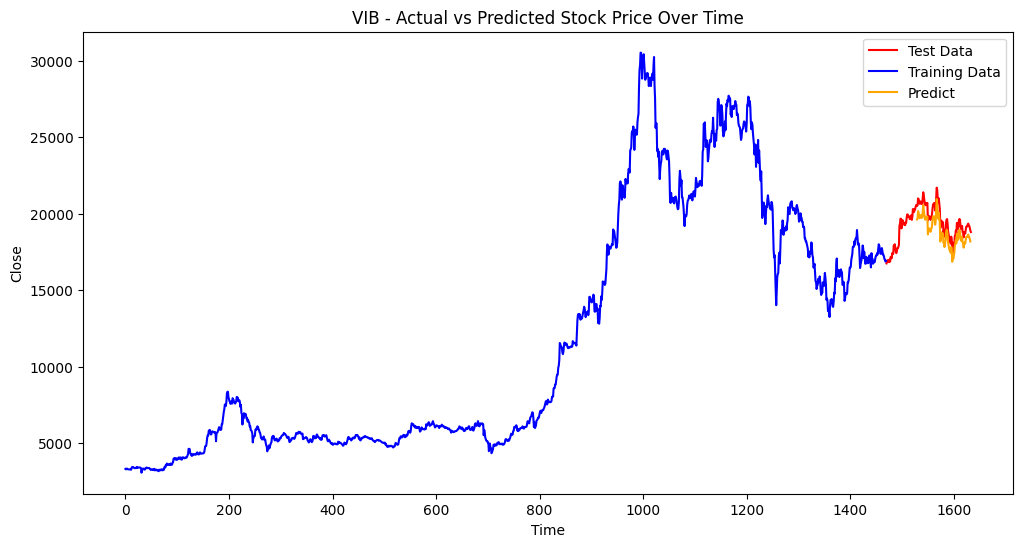

In [22]:
plt.figure(figsize=(12, 6))
n_future = 60

# Plot actual values
plt.plot(range(train_size, train_size+test_size+1),test_back.reshape(-1,1), linestyle='-',  color='r', label='Test Data')
plt.plot(range(train_size), train_back, linestyle='-', color='b', label='Training Data')
#predict_date = Test_data['Time'];
plt.plot(range(train_size+n_future-1, train_size+test_size),  y_pred_future, label='Predict', linestyle='-',  color='orange')
# # Plot predicted values
#plt.plot( test_Date, y_pred, label='Predicted', linestyle='-',  color='b')

plt.title('VIB - Actual vs Predicted Stock Price Over Time')
plt.xlabel('Time')
plt.ylabel('Close')
plt.legend()

plt.show()

In [23]:
n_past = 1
n_days_for_prediction= 60

#print(test_data.reshape(1,-1).T.shape)

test_for_forecast = test_data.reshape(1,-1).T

x_forecast = []
y_forecast = []

for i in range(n_days_for_prediction):
  # B1 Duyệt dữ liệu test n ngày gần nhất => bỏ vào x tạm
  x = np.array(test_for_forecast[(-60):])
  print(x.shape)
  x = x.T.reshape(x.shape[1], x.shape[0], 1)
  print(x.shape)

  # B2 dùng predict để chạy 1 ngày
  y = model.predict(x)
  # B3 thêm data ngày đó vào y_forecast, test_for_forecast và append x vào x_forecast
  y_c = np.repeat(y, x.shape[1], axis=-1)
  y_pr = scaler.inverse_transform(y_c)[:,0]

  x_forecast.append(x)
  y_forecast.append(y_pr)
  test_for_forecast = np.append(test_for_forecast, y).reshape(-1,1)
  print(test_for_forecast.shape)
  #test_for_forecast.append(y)
  # B4 lặp lại đến ngày thứ 60

x_forecast = np.array(x_forecast)
y_forecast = np.array(y_forecast)

(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 38ms/step
(165, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 40ms/step
(166, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 40ms/step
(167, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 40ms/step
(168, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 45ms/step
(169, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 41ms/step
(170, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 41ms/step
(171, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 39ms/step
(172, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 39ms/step
(173, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 40ms/step
(174, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 38ms/step
(175, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 37ms/step
(176, 1)
(60, 1)
(1, 60, 1)
1/1 [================

In [24]:
print(y_forecast)

[[18093.83 ]
 [17463.176]
 [16880.174]
 [16366.745]
 [15919.658]
 [15529.716]
 [15187.732]
 [14885.503]
 [14616.081]
 [14373.776]
 [14154.027]
 [13953.215]
 [13768.488]
 [13597.6  ]
 [13438.769]
 [13290.573]
 [13152.073]
 [13023.073]
 [12903.473]
 [12792.808]
 [12690.039]
 [12594.596]
 [12505.947]
 [12423.574]
 [12347.081]
 [12276.04 ]
 [12210.006]
 [12148.547]
 [12091.27 ]
 [12037.819]
 [11987.881]
 [11941.176]
 [11897.458]
 [11856.504]
 [11818.117]
 [11782.116]
 [11748.338]
 [11716.688]
 [11687.046]
 [11659.28 ]
 [11633.261]
 [11608.955]
 [11586.309]
 [11565.319]
 [11545.924]
 [11527.992]
 [11511.427]
 [11496.187]
 [11482.166]
 [11469.255]
 [11457.355]
 [11446.377]
 [11436.239]
 [11426.873]
 [11418.214]
 [11410.204]
 [11402.793]
 [11395.935]
 [11389.586]
 [11383.709]]


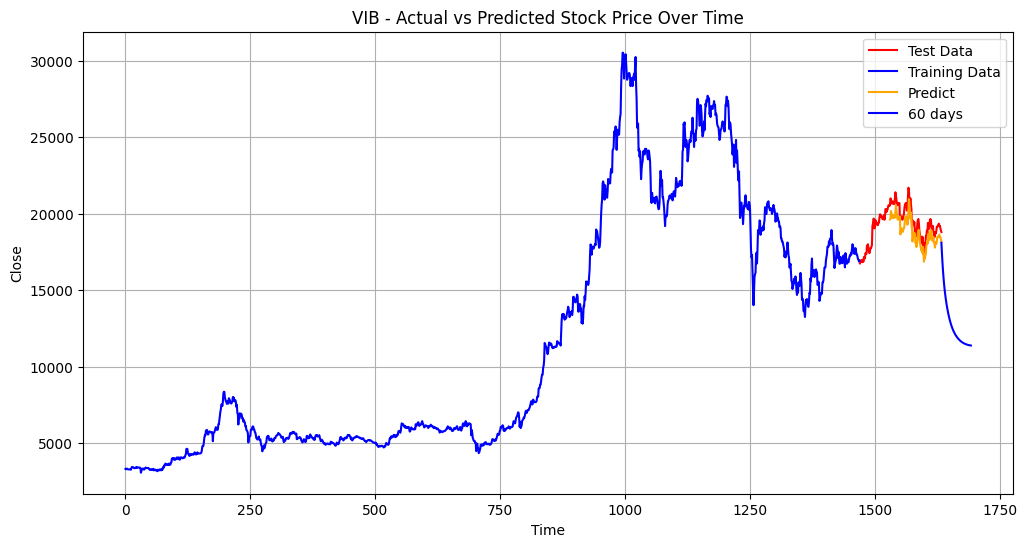

In [25]:
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(range(train_size, train_size+test_size+1),test_back.reshape(-1,1), linestyle='-',  color='r', label='Test Data')
plt.plot(range(train_size), train_back, linestyle='-', color='b', label='Training Data')
# Plot predict test and actual test
plt.plot(range(train_size + 60, train_size + test_size+1),  y_pred_future, label='Predict', linestyle='-',  color='orange')
# Plot 60 days
plt.plot(range(train_size+test_size, train_size+test_size+60), y_forecast, linestyle='-', color='b', label='60 days')

plt.title('VIB - Actual vs Predicted Stock Price Over Time')
plt.xlabel('Time')
plt.ylabel('Close')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
def RSME (data1, data2):
    return np.sqrt(np.mean((data1-data2)*(data1-data2)))
def MAE (data1, data2):
    return np.mean(np.absolute(data1-data2))
def MAPE (pred, actual):
    return np.mean(np.absolute((pred-actual)/actual))*100

In [27]:
print("RSME: ", RSME(y_pred_future, test_back[-60:]))
print("MAE: ", MAE(y_pred_future, test_back[-60:]))
print("MAPE: ", MAPE(y_pred_future, test_back[-60:]))

RSME:  1013.221097263723
MAE:  839.1217366536458
MAPE:  4.450590305243265


In [28]:
def MSLE (pred, actual):
    return np.mean((np.log(1+actual)-np.log(1+pred))*(np.log(1+actual)-np.log(1+pred)))
print("MSLR: ", MSLE(y_pred_future, test_back[14:]))

MSLR:  0.005852960537940852
